# Best reward experiment

In [24]:
import pandas as pd
from helpers.paths import Path


df = pd.read_csv(Path.data/"best_reward.csv")
df_2 = pd.read_csv(Path.data/"best_reward_square.csv")

/var/folders/kz/2zydzyyx1nn9y3bf433qq35c0000gn/T/ipykernel_66050/3138906533.py:5: DtypeWarning: Columns (30,45,66,70,71,74,75,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path.data/"best_reward.csv")
/var/folders/kz/2zydzyyx1nn9y3bf433qq35c0000gn/T/ipykernel_66050/3138906533.py:6: DtypeWarning: Columns (40,50,66,70,71,72,73,74,77,78,80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv(Path.data/"best_reward_square.csv")


In [46]:
# Get sum of error for each runpip 
df_error = df[~df["tracking_error"].isna()].groupby(["run", "algorithm", "reward_type"])["tracking_error"].sum().reset_index()
df_error_2 = df_2[~df_2["tracking_error"].isna()].groupby(["run", "algorithm", "reward_type"])["tracking_error"].mean().reset_index()

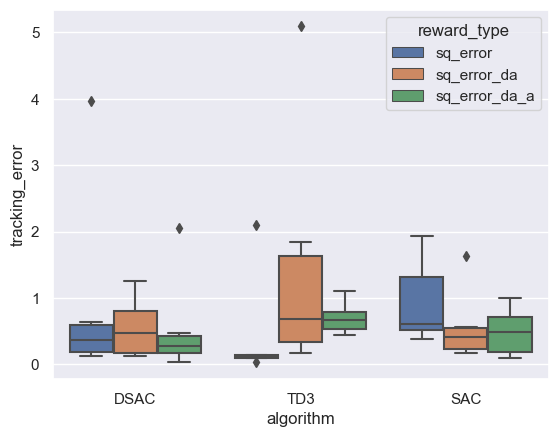

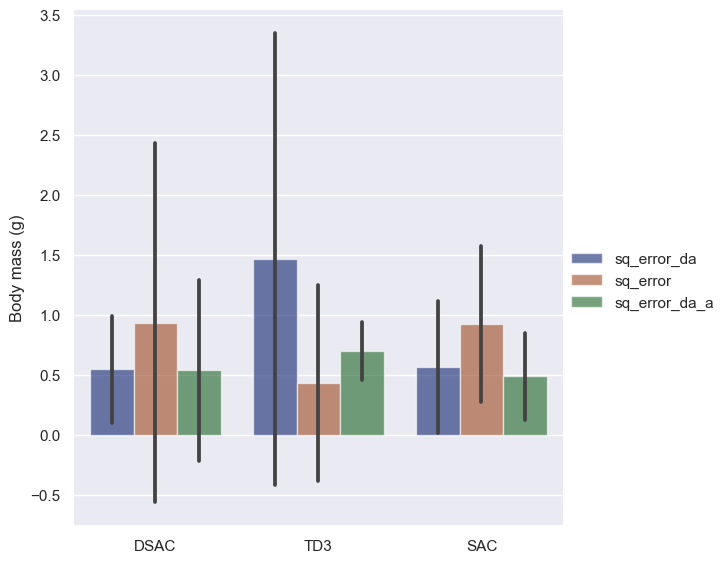

In [47]:
hue_order=['sq_error', 'sq_error_da', 'sq_error_da_a']
sns.boxplot(data=df_error, y="tracking_error", x="algorithm", hue="reward_type", hue_order=hue_order)
# df_error

g = sns.catplot(
    data=df_error, kind="bar",
    x="algorithm", y="tracking_error", hue="reward_type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")


<AxesSubplot: xlabel='algorithm', ylabel='tracking_error'>

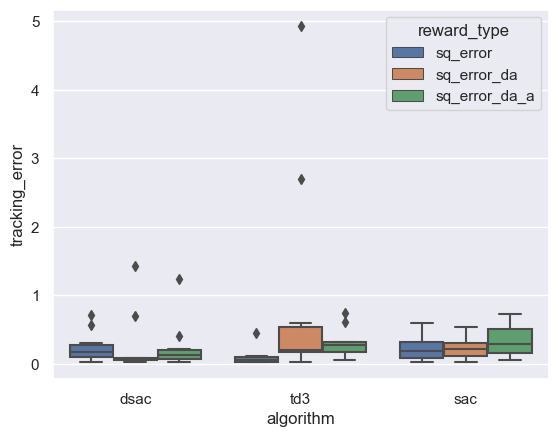

In [38]:
sns.boxplot(data=df_error_2, y="tracking_error", x="algorithm", hue="reward_type", order=["dsac", "td3", "sac"], hue_order=hue_order)


<AxesSubplot: xlabel='algorithm', ylabel='tracking_error'>

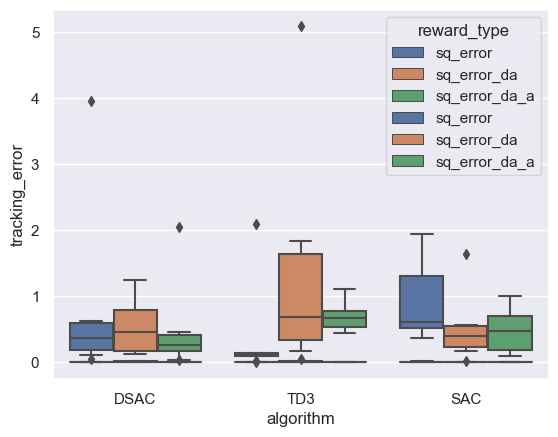

In [53]:
df_sum = df[~df["tracking_error"].isna()].groupby(["run", "algorithm", "reward_type"])["tracking_error"].sum().reset_index()
df_mean = df[~df["tracking_error"].isna()].groupby(["run", "algorithm", "reward_type"])["tracking_error"].mean().reset_index()
sns.boxplot(data=df_sum, y="tracking_error", x="algorithm", hue="reward_type", hue_order=hue_order)



<AxesSubplot: xlabel='algorithm', ylabel='tracking_error'>

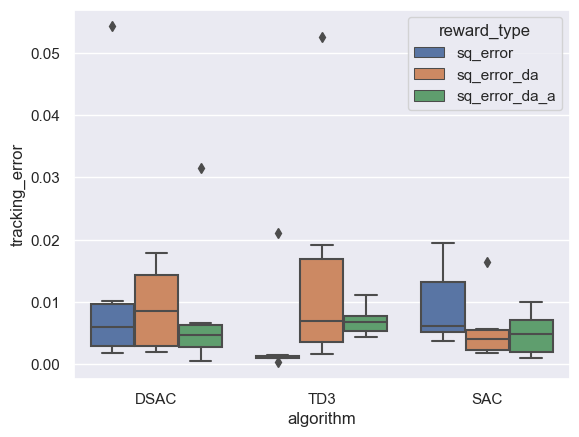

In [54]:
sns.boxplot(data=df_mean, y="tracking_error", x="algorithm", hue="reward_type", hue_order=hue_order)

In [95]:
# df_mean[df_mean['algorithm']=="TD3"]
# df_error = df[~df["tracking_error"].isna()].groupby(["run", "algorithm", "reward_type"])["tracking_error"].sum().reset_index()
# df_error.groupby(["algorithm", "reward_type"])["tracking_error"].sum()
df[(df["run"]=="amber-disco-33") & (df["episode_step"]==1.0)]["tracking_error"]

17282   NaN
17283   NaN
Name: tracking_error, dtype: float64

In [101]:
df = pd.read_csv(Path.data/"best_reward_2.csv")
df.groupby(["run", "algorithm", "reward_type"])["episode_step"].count()


run                  algorithm  reward_type  
amber-forest-51      TD3        sq_error_da      400
bumbling-water-55    TD3        sq_error_da_a    400
charmed-mountain-58  TD3        sq_error_da_a    400
crisp-glade-62       TD3        sq_error         400
dry-cosmos-67        TD3        sq_error_da_a    394
dutiful-forest-54    TD3        sq_error_da      400
eternal-surf-66      TD3        sq_error_da      391
feasible-flower-60   TD3        sq_error_da      385
fiery-flower-61      TD3        sq_error_da_a    400
fiery-wood-50        TD3        sq_error         400
genial-music-63      TD3        sq_error_da      400
glad-serenity-65     TD3        sq_error         400
kind-plasma-48       DSAC       sq_error_da      250
lucky-water-57       TD3        sq_error_da      393
mild-totem-53        TD3        sq_error         400
polar-yogurt-64      TD3        sq_error_da_a    400
sage-dawn-56         TD3        sq_error         400
smart-fog-49         DSAC       sq_error_da_a    266
